In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/lankenau/isotools/src')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os

path = '/project/hfa_work/ENCODE/data'
alignment_path = 'alignment_v45'
genome_file = 'GRCh38.p14.genome.fa'
genome_path = os.path.join(path, 'gencode_human/version_45', genome_file)

In [4]:
metadata_file = 'reads/metadata_tissue.tsv'
metadata = pd.read_csv(os.path.join(path, metadata_file), sep='\t')

In [10]:
import logging
from isotools import Transcriptome
from isotools.plots import plot_saturation, plot_rarefaction, plot_bar
from isotools import __version__ as isotools_version
# set up logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logger=logging.getLogger('isotools')
logger.info(f'This is isotools version {isotools_version}')

INFO:This is isotools version 0.3.5rc10


In [6]:
isoseq = Transcriptome.load("results/isoseq_v45.pkl")

INFO:loading transcriptome from results/isoseq_v45.pkl


In [7]:
isoseq_strict = Transcriptome.load("results/isoseq_v45_strict.pkl")

INFO:loading transcriptome from results/isoseq_v45_strict.pkl


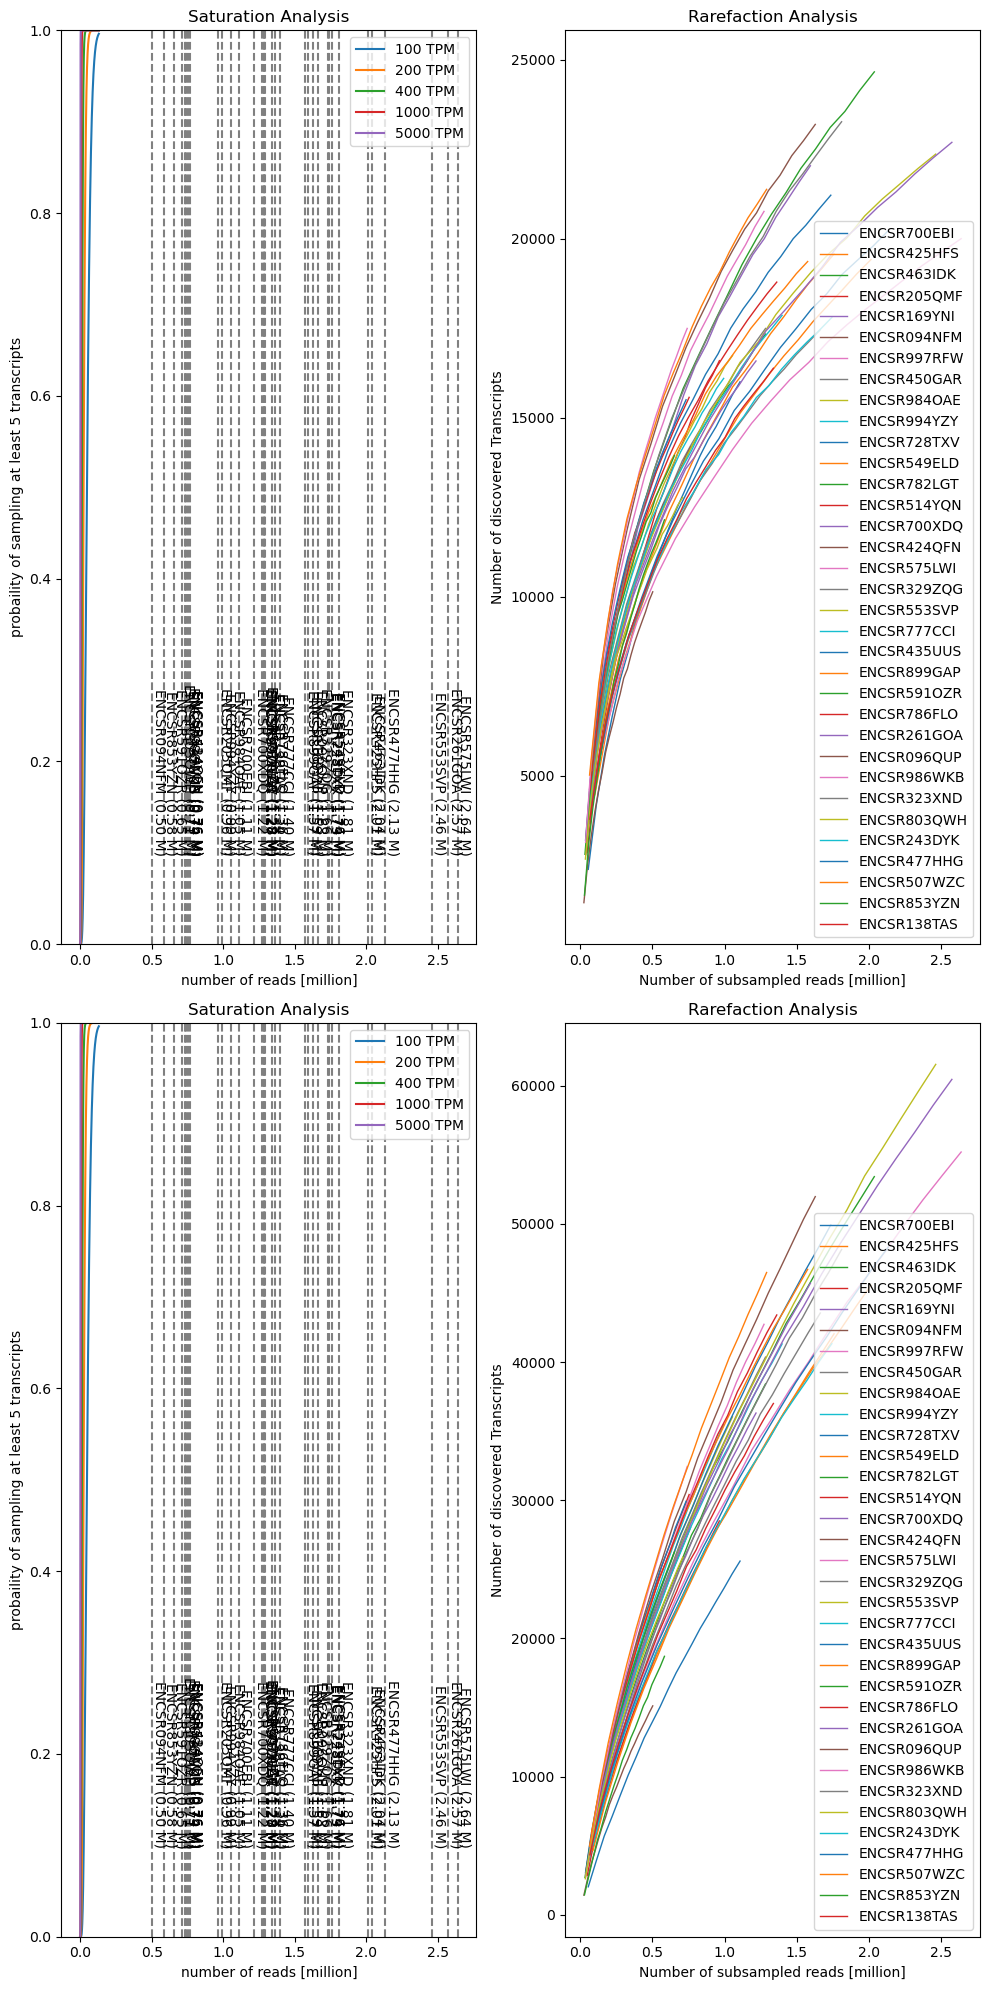

In [9]:
plt.rcParams["figure.figsize"] = (10,20)
fig, axs=plt.subplots(2,2)

plot_saturation(isoseq,cov_th=5, expr_th=[100, 200, 400, 1000, 5000],
                x_range=(1e2,1.3e5,1e2), ax=axs[0, 0])

rarefraction, total=isoseq.rarefaction(min_coverage=2, tr_filter={'query':'FSM'})
plot_rarefaction(rarefraction, total=total, ax=axs[0, 1])

plot_saturation(isoseq_strict,cov_th=5, expr_th=[100, 200, 400, 1000, 5000],
                x_range=(1e2,1.3e5,1e2), ax=axs[1, 0])

rarefraction, total=isoseq_strict.rarefaction(min_coverage=2, tr_filter={'query':'FSM'})
plot_rarefaction(rarefraction, total=total, ax=axs[1, 1])

fig.tight_layout()

In [11]:
f_stats_groups=isoseq.filter_stats(
    tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'],
    groups=isoseq.groups(),
    weight_by_coverage=True,
    min_coverage=2)

f_stats_samples=isoseq.filter_stats(
    tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'],
    weight_by_coverage=True,
    min_coverage=2)

f_stats_groups_strict=isoseq_strict.filter_stats(
    tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'],
    groups=isoseq_strict.groups(),
    weight_by_coverage=True,
    min_coverage=2)

f_stats_samples_strict=isoseq_strict.filter_stats(
    tags=['RTTS','FRAGMENT','INTERNAL_PRIMING'],
    weight_by_coverage=True,
    min_coverage=2)

<Axes: title={'center': 'Expressed Transcripts > 2 reads'}, ylabel='fraction of reads'>

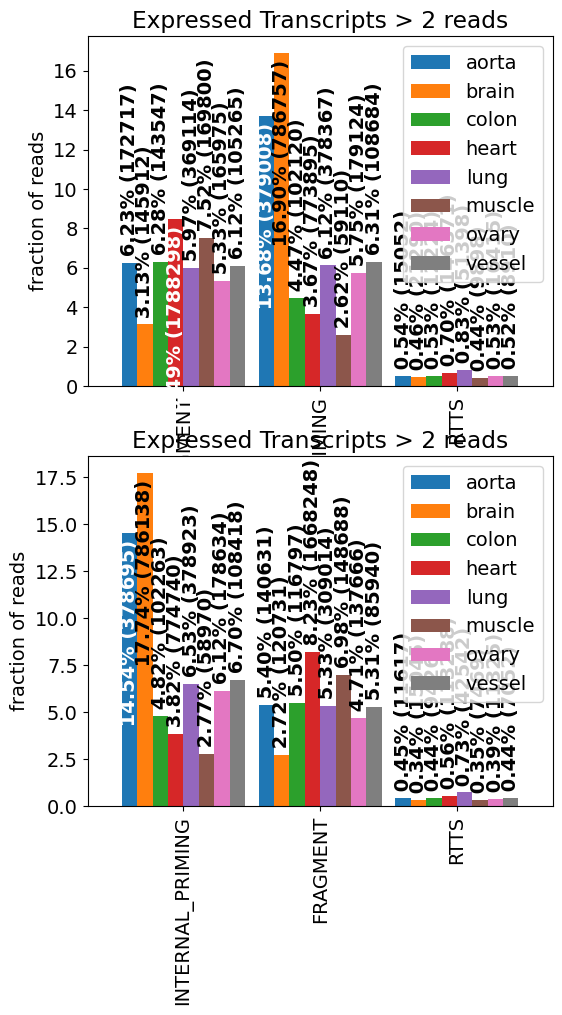

In [19]:
plt.rcParams["figure.figsize"] = (6,10)
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(2,1)

group_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# groupwise statistics
plot_bar(f_stats_groups[0], ax=axs[0], drop_categories=['PASS'], bar_width=.9,
         legend=True, colors=group_colors, **f_stats_groups[1])
# # sample wise statistics
# plot_bar(f_stats_samples[0], ax=axs[0, 1], drop_categories=['PASS'], bar_width=.9,
#          legend=True, **f_stats_samples[1])

# groupwise statistics
plot_bar(f_stats_groups_strict[0], ax=axs[1], drop_categories=['PASS'], bar_width=.9,
         legend=True, colors=group_colors, **f_stats_groups_strict[1])
# # sample wise statistics
# plot_bar(f_stats_samples_strict[0], ax=axs[1, 1], drop_categories=['PASS'], bar_width=.9,
#          legend=True, **f_stats_samples_strict[1])